BBM409 - Introduction to Machine Learning Laboratory

Instructor: Ahmet Burak Can

TA: Burçak Asal

21827981: Yunus Emre Yazıcı<br>
2200356856: Ali Kemal Tamkoç

# Assignment 2

**Instructions**. The goal of this problem set is to make us understand and familiarize with decision tree algorithm and pruning process. We will experiment with decision tree model (by using ID3 algorithm) on the Employee Attribute Prediction dataset.

## PART 1: Employee Attribute Prediction

### Problem Definiton and Data

In this part of the assignment, we will implement a decision tree model to predict attrition attribute on employees.

The dataset is provided for the training phase. The dataset will be splitted into two sets; training set which will be used to learn model and create the tree, the test set which will be used to measure the success of our learned model. As it was stated on the manual, we used the 5-Fold cross-validation method to validate our learned model. We implemented the ID3 Algorithm within the scope of our decision tree model.

### Implementation of the Decision Tree: Node

In [1]:
class Node:
    def __init__(self, title=None, count=None, info_gain=0, decision=None, data_set=None, attributes=None,
                 parent=None) -> None:
        self.title = title
        self.children = []
        self.count = count
        self.info_gain = info_gain
        self.decision = decision
        self.data_set = data_set
        self.attributes = attributes
        self.parent = parent

    def create_children(self) -> None:
        """
        When a node is created from an attribute, this function automatically creates children nodes from node's values
        In this way the path between the next node and attribute node is created.

        Arguments:
        Returns:
        """
        for key in self.count.keys():
            if key == "general":
                continue
            decision = None
            if self.count[key][0] == 0:
                decision = "No"
            elif self.count[key][1] == 0:
                decision = "Yes"
            child = Node(key, self.count[key], decision=decision, parent=self)
            self.children.append(child)

    def find_most_common(self) -> str:
        """
        Finds the most common result in the node
        For attributes count is a dictionary, for attribute values its a tuple

        Arguments:

        Returns:
            decision [str]: returns "Yes" or "No", depending on the number of "Yes" and "No"
        """
        if type(self.count) == tuple:
            yes_count = self.count[0]
            no_count = self.count[1]
        else:
            yes_count = self.count["general"][0]
            no_count = self.count["general"][1]

        if yes_count > no_count:
            return "Yes"
        return "No"

    def is_twig(self) -> bool:
        """
        Checks if the node is twig
        The condition of the twig is that the node should not have any other paths to another attribute node
        So, if a node is twig, all of its children have a decision attribute assigned

        Arguments:

        Returns:
            bool [bool]: returns if the node is a twig or not
        """
        for child in self.children:
            if child.decision is None:
                return False
        return True

In our implementation the nodes include title, children, count, info_gain (information gain), decision, data_set, attributes, parent attributes. The nodes represent both attributes and their distinct values. So, for example in our data set, we have "Gender" attribute and it has "Male", "Female" options. We create 3 nodes separetly for Gender, Male and Female. However, Male and Female nodes are children nodes of Gender node. So, in this way the nodes are used as a normal node itself and as a path at the same time.

**Title**: Name of the attribute or its values.
<br>
**Children**: A list of children nodes. It corresponds to list of values for attribute nodes and other attributes for value nodes.
<br>
**Count**: The count of the values. They are kept in order to calculate entropy, information gain and to create a resultant decision for the node as either "Yes" or "No" for later usages.
<br>
**Info_gain**: The information gain value for the corresponding node. It is used for making pruning process easier in the next steps.
<br>
**Decision**: The decision attribute which is set for only leaf/twig nodes. If the node is not twig, then the attribute is None.
<br>
**Data_set**: The corresponding data set which is used while creating the node.
<br>
**Attributes**: The list of the attributes that are used during the tree creation. As the tree gets deeper, the attributes are filtered more and to make the process easier, this value is kept.
<br>
**Parent**: Parent node, which is used in pruning process, while the prune is taken back.

**def create_children(self)** -> When a node of an attribute is created, some other nodes are created for its corresponding values (such as Sunny and Rainy for Overcast attribute) and added to children list. So, we can keep the track while tree creation process and assign a decision if the node is a leaf.

**def find_most_common(self)** -> Finds the most common value from count attribute. This function is used during the pruning while deleting an attribute node from the tree and finding its most common value.

**def is_twig(self)** -> Returns if the given node is twig or not.

**Important Note** The leaf nodes are the value nodes. A node is twig if it only has value nodes as children and does not expend to another attribute. In order to decide that, we check the **decision attribute**. If the value nodes does not extend to another attribute, then they have a valid decision attribute.

### Implementation of Decision Tree
We implemented the Decision Tree according to the ID3 Algorithm.
From the Tom Mitchell's Machine Learning book The algorithm is described as:

```
Create a Root node for the tree
If all Examples are positive, Return the single-node tree Root, with label = +
If all Examples are negative, Return the single-node tree Root, with label = -
If Attributes is empty, Return the single-node tree Root, with label = most common value of
Target_attribute in Examples
Otherwise Begin
    At the attribute from Attributes that best* classifies Examples
    The decision attribute for Root := A
    For each possible value, vi, of A,
    Add a new tree branch below Root, corresponding to the test A  vi
    Let Examples_{vi} be the subset of Examples that have value vi for A
    If Examples_{vi} is empty
        Then below this new branch add a leaf node with label = most common
        value of Target attribute in Examples
    Else below this new branch add the subtree
    ID3(Examples_{vi}, Target_attribute, Attributes - ( A ) )
    
The best classifying attribute is the attribute which has the biggest information gain
```

In [2]:
import utility
import numpy as np


class DecisionTree:
    def __init__(self):
        self.root = None
        self.twig_list = []

    def create_tree(self, df_array: list, attr_list: list) -> None:
        """
        Creates the tree starting from its root node

        Arguments:
            df_array [np.ndarray]: The array of the given data set
            attr_list [list]: The list of the attribute names
        Returns:
        """
        counts = {}
        selected_attribute, max_gain = find_max_gain(df_array, attr_list, counts)
        self.root = Node(selected_attribute, count=counts[selected_attribute], info_gain=max_gain, attributes=attr_list,
                         data_set=df_array)
        self.root.create_children()
        self._generate_leafs()

    def _generate_leafs(self) -> None:
        """
        Creates the rest of the tree
        Uses a node list to keep track of the new created nodes
        Every node that is created from an attribute is added to this node list
        Then the code takes every node and check its children, if a child has a decision, it skips that child
        If not, it continues and creates other attribute nodes with filtered data
        If there is no selected attr, or max_gain == 0, then it does not create a child but assigns the most common value
        from that child
        
        Arguments:
        
        Returns:
        
        """
        node_list = [self.root]
        while node_list:
            current_node = node_list.pop(0)
            attr = current_node.title
            attr_list = current_node.attributes.copy()
            attr_index = attr_list.index(attr)
            attr_list.remove(attr)

            counts = {}
            for child in current_node.children:
                if child.decision is not None:
                    continue
                data_set = filter_data_set(current_node.data_set, attr_index, child.title)
                data_set = np.delete(data_set, attr_index, axis=1)
                selected_attr, max_gain = find_max_gain(data_set, attr_list, counts)

                if selected_attr is not None:
                    new_node = Node(selected_attr, count=counts[selected_attr], info_gain=max_gain, attributes=attr_list,
                                    data_set=data_set, parent=child)
                    new_node.create_children()
                    child.children.append(new_node)
                    node_list.append(new_node)
                else:
                    child.decision = child.find_most_common()

    def prune(self) -> (Node, Node):
        """
        Prunes the tree with using twig list
        Find the least information gain node then deletes it from the list
        After deletion checks its parent whether it turns a twig or not, if yes adds the parent to the list

        Arguments:

        Returns:
            temp_node [node]: the deleted node from the twig list
            temp_node.parent [node]: the parent of the deleted node, in case of reverting the pruning
        """
        min_gain = float('inf')
        temp_node = None
        for twig in self.twig_list:
            if twig.info_gain < min_gain:
                min_gain = twig.info_gain
                temp_node = twig
        temp_node.parent.decision = temp_node.find_most_common()
        self.twig_list.remove(temp_node)
        temp_node.parent.children.clear()
        
        if temp_node.parent.parent.is_twig():
            self.twig_list.append(temp_node.parent.parent)

        return temp_node, temp_node.parent

    def revert_prune(self, twig: Node, parent: Node) -> None:
        """
        Reverts one step of the pruning operation 
        Add the twig back to the tree, twig list and checks if its parent is in twig list
        If yes, deletes the parent from the twig list
        
        Arguments:

        Returns:
            
        """
        if twig.parent.parent.is_twig():
            self.twig_list.remove(twig.parent.parent)
        parent.children.append(twig)
        self.twig_list.append(twig)
        parent.decision = None

    def find_twigs(self, tree_node: Node) -> None:
        """
        Finds the twigs in the tree and adds them to the twig list before pruning operation starts
        Works similar to the depth first search in a recursive manner

        Arguments:
            tree_node [Node]: the current node of the tree
        Returns:

        """
        if not tree_node.is_twig():
            for child in tree_node.children:
                if child.decision is None:
                    self.find_twigs(child.children[0])
        else:
            self.twig_list.append(tree_node)
            return

    def predict(self, test: np.array) -> str:
        """
        Makes a prediction of the given test data

        Arguments:
            test [np.array]: A row from the test data
        Returns:
            decision [str]: Returns the decision found
        """
        current_node = self.root
        attr_list = self.root.attributes
        child_index = 0
        while child_index < len(current_node.children):
            child = current_node.children[child_index]
            attr_index = attr_list.index(current_node.title)
            if test[attr_index] == child.title:

                if child.decision is not None:
                    return child.decision
                current_node = child.children[0]
                child_index = 0
            else:
                child_index += 1

    def print_rules(self, tree_node: Node, print_list: list) -> None:
        """
        Prints out the whole tree
        Because the tree has different branches from a single node, adds every node that is not the end of the path to
        the print_list
        When it reaches to the end, prints out the nodes, then deletes the last node added
        Works recursively, in the first call tree_node is root, print_list is empty list

        Arguments:
            tree_node [Node]: the current node of the tree
            print_list [list]: the list of the nodes which are printed out recursively
        Returns:

        """
        print_list.append(tree_node)
        for child in tree_node.children:
            if child.decision is None:
                print_list.append(child)
                self.print_rules(child.children[0], print_list)
                print_list.remove(child)
            else:
                counter = 0
                for temp_node in print_list:
                    if temp_node.decision is None:
                        if counter % 2 == 0:
                            print(f"({temp_node.title} = ", end="")
                        else:
                            print(f"{temp_node.title}) ^ ", end="")
                        counter += 1
                print(f"{child.title}) -> {child.decision} ")

        print_list.remove(tree_node)


### Implementation of Decision Tree: Utility Functions

#### Handling the contionuous variable

We have to implement some helper functions which are needed for the ID3 Implementaion such as a function that converts continuos values to discrete values and two functions for calculating entropy and informaton gain values. In our given dataset there are also some attributes which have continuous values. To handle this we make a search on the dataset and filter the attributes. Then we divide the values into 3 intervals (depending on the max and min values on the attribute) and assign a new value depending on their intervals such as "Low", "Mid" and "High". The algorithm can be described as:

In [3]:
def _create_bins(lower_bound: int, higher_bound: int, interval_num: int) -> list:
    """
        Takes min, max values of the columns and interval number
        Creates number of intervals depending on the max, min values
        Arguments:
            lower_bound [int]: Min. value in the column
            higher_bound [int]: Max. value in the column
            interval_num [int]: Number of intervals
        Returns:
            bins [list]: List of the tuples of the intervals
    """
    bins = []
    interval_size = (higher_bound - lower_bound) / interval_num
    for num in range(interval_num):
        bins.append((lower_bound + (interval_size * num), (lower_bound + (interval_size * (num + 1)))))

    return bins

**_create_bins(...)** function creates the proper intervals for the given attribute with using min, max values

In [4]:
def discrete_data(data_set: np.ndarray, cont_indexes: list) -> None:
    """
        Discrete the continuous attribute in the given data set
        First creates intervals depending on the max, min values of the given column
        Then matches the values in the column with labels

        Arguments:
            data_set [np.array]: the given data set
            cont_indexes [list]: the indexes of the cont. attributes in the given data set
        Returns:
            accuracy [float]: The ratio between correct predictions and number of predictions
    """
    labels = ["Low", "Mid", "High"]
    for index in cont_indexes:
        data_array = data_set[:, index]
        max_val = np.max(data_array)
        min_val = np.min(data_array)
        bins = _create_bins(min_val, max_val, len(labels))

        for data_num in range(len(data_array)):
            for interval_num in range(len(bins)):
                if interval_num == len(bins) - 1:
                    if bins[interval_num][1] >= data_array[data_num] >= bins[interval_num][0]:
                        data_array[data_num] = labels[interval_num]
                        break
                else:
                    if bins[interval_num][1] > data_array[data_num] >= bins[interval_num][0]:
                        data_array[data_num] = labels[interval_num]
                        break

**discrete_data(...)** The function that converts continuos values to discrete values takes a 2D array (data set) as an argument and another list to know which columns or features have continuos values. The filtering of continuous indexes are made in main part of the code (Main.py). The function first creates the intervals with using **_bins(...)** function, then places the values of the selected column into the intervals. Depending on the interval, there's a corresponding value in **labels** list. In the intervals the maximun value and the minimum value are also included.
<br>
<br>
<center>Interval = [min_value, x), [a, b) ... [c, max_value]

The implementation also includes the implementation of entropy (calculate_entropy) and information gain (calculate_gain),  respectively defined as: <br><br>
$Entropy(S) \equiv \sum_{i = 1}^{c}{-p_{i}\log_{2}{p_{i}}}$ <br><br>
$Gain(S, A) \equiv Entropy(S) - \sum_{v \in Values(A)} \dfrac{|S_{v}|}{|S|}Entropy(S_{v})$

In [5]:
def calculate_entropy(data_set: np.ndarray, attr_index: int, outcome_index: int):
    """
        Calculates the entropy of given attribute from the given data set
        The outcome index is the place of the outcome which used for finding out the outcome of the datas in the
        data set

        Creates a dictionary "count" before calculating the numbers of "Yes" and "No" results. It is used later in the
        implementation of prune methods
        Arguments:
            data_set [dict]: the dictionary of the entropy results of an attribute.
                                Used as a dictionary for different values in the column
            attr_index [int]: index of the attribute whose entropy is calculated
            outcome_index [int]: index of the result attribute, "Yes" and "No"s in this case
        Returns:
            entropy_result [dict]: The entropy value of the given attribute and its values
            count [dict]: The count of "Yes" and "No" results of the given attribute and its values
    """
    import math
    
    # Creates the count dictionary with different values of the given attribute
    count = {"general": (0, 0)}
    for data_index in range(len(data_set)):
        count[data_set[data_index][attr_index]] = (0, 0)

    # Calculates the number of "Yes" and "No" at the index of outcome for the attribute values
    for index in range(len(data_set)):
        data = data_set[index][attr_index]
        if data_set[index][outcome_index] == "Yes":
            count[data] = (count[data][0] + 1, count[data][1])
            count["general"] = (count["general"][0] + 1, count["general"][1])
        else:
            count[data] = (count[data][0], count[data][1] + 1)
            count["general"] = (count["general"][0], count["general"][1] + 1)
    
    # Entropy calculation
    entropy_result = {}
    for key in count.keys():
        data = count[key]
        positive = data[0] / (data[0] + data[1])
        negative = data[1] / (data[0] + data[1])

        if not positive or not negative:
            entropy_result[key] = 0
            continue
        entropy_result[key] = (-positive * math.log2(positive)
                               ) - (negative * math.log2(negative))

    return entropy_result, count

**calculate_entropy(...)**
<br>
The function takes the given data set then creates an dictionary in order the count different values in the given column. Then, with using the outcome attribute, which in our case "Attrition" attribute is the outcume, it compares if the value of the selected row is either "Yes" or "No". With using the count calculates the entropy and returns entropy with the count dictionary.

In [6]:
def calculate_gain(entropy_result: dict, count: dict) -> float:
    """
        From a given entropy value and number of counts of the attribute calculates the information gain

        Arguments:
            entropy_result [dict]: the dictionary of the entropy results of an attribute.
                                Used as a dictionary for different values in the column
            count [dict]: the count of "Yes", "No" results of an attribute and its values
        Returns:
            result [float]: The information gain of the given attribute
    """
    result = entropy_result["general"]
    general_total = count["general"][0] + count["general"][1]
    for key in entropy_result.keys():
        if key == "general":
            continue
        attr_total = count[key][0] + count[key][1]
        result -= (attr_total / general_total) * entropy_result[key]

    return result

**calculate_gain(...)** <br>
The function calculates the information gain of the given column from the data set with using its entropy and count attributes. The **entropy_result** and **count** parameters are calculated in **calculate_entropy(...)** method. The "general" count is the sum up of all results regardless of the columns value.

In [7]:
def find_max_gain(data_set, attr_list, counts):
    """
        Finds the attribute from the given attribute list which has the most information gain
        Arguments:
            data_set [np.array]: the data set of the model
            attr_list [list]: the attributes of the selected node
            counts [dict]: the number of "Yes" and "No" of the attribute and its values
        Returns:
            selected_attr [str]: The name of the selected attribute
            max_gain [int]: The value of the information gain of the selected attribute
    """
    selected_attr = None
    max_gain = 0
    for i in range(len(attr_list)):
        if i == 1:
            continue
        entropy, count = calculate_entropy(data_set, i, 1)
        gain = calculate_gain(entropy, count)
        counts[attr_list[i]] = count
        if gain > max_gain:
            max_gain = gain
            selected_attr = attr_list[i]
    return selected_attr, max_gain

**find_max_gain(...)** <br>
An helper function to calculate maximum information gain in the given data set.

In [8]:
def filter_data_set(data_set: np.ndarray, attr_index: int, attr_value: str) -> list:
    """
        Filters the data set depending on the attribute value at the attribute index
        Arguments:
            data_set [np.array]: the data set of the model
            attr_index [int]: The attribute that is used while filtering the data set
            attr_value [int]: The value of the given attribute in data set
        Returns:
            filtered_result [float]: The filtered data set depending on the attribute and its value
    """
    filtered_result = []
    for data in data_set:
        if data[attr_index] == attr_value:
            filtered_result.append(data)

    return filtered_result

**filter_data_set(...)** <br>
As the tree gets deeper, the columns in the data set get filtered. Such as when we pick an attribute X, which has 3 different values a, b, and c, if we go further, first we filter the data a, b, or c (Let's assume a in this case) and get the data set includes only the rows which have value of "a", then we repeat the calculation. In order to filter the data set in this way. We use this function

In [9]:
def calculate_accuracy(test_set: np.ndarray, predictions: list) -> float:
    """
        Calculates accuracy with matching test_set and predictions.
        Arguments:
            test_set [np.array]: the test set of the model
            predictions [list]: the predictions of the test set from the tree
        Returns:
            accuracy [float]: The ratio between correct predictions and number of predictions
    """
    TP_TN = 0
    for test_index in range(len(test_set)):
        if test_set[test_index][1] == predictions[test_index]:
            TP_TN += 1
    accuracy = TP_TN / len(predictions)
    return accuracy


def calculate_recall(test_set: np.ndarray, predictions: list) -> float:
    """
        Calculates Precision metric score of the model with matching (T)rue (P)ositive and
        (F)alse (N)egative values
        Arguments:
            test_set [np.array]: the test set of the model
            predictions [list]: the predictions of the test set from the tree
        Returns:
            recall [float]: TP / (TP+FN)
    """
    TP = 0
    FN = 0
    for i in range(len(test_set)):
        if test_set[i][1] == "Yes" and predictions[i] == "Yes":
            TP += 1
        elif test_set[i][1] == "Yes" and predictions[i] == "No":
            FN += 1
    return TP/(TP+FN)


def calculate_precision(test_set: np.ndarray, predictions: list) -> float:
    """
        Calculates Precision metric score of the model with matching (T)rue (P)ositive and
        (F)alse (P)ositive values
        Arguments:
            test_set [np.ndarray]: the test set of the model
            predictions [list]: the predictions of the test set from the tree
        Returns:
            precision [float]: TP / (TP+FP)
    """
    TP = 0
    FP = 0
    for i in range(len(test_set)):
        if test_set[i][1] == "Yes" and predictions[i] == "Yes":
            TP += 1
        elif predictions[i] == "Yes" and test_set[i][1] == "No":
            FP += 1
    return TP/(TP+FP)


def calculate_f1_score(recall: float, precision: float) -> float:
    """
        Calculates F1 metric score of the model

        Arguments:
            recall [flot]: recall value of the model
            precision [float]: precision value of the model
        Returns:
            f1_score [float]: 2 * (recall * precision) / (recall + precision)
    """
    return 2 * (recall * precision) / (recall + precision)


def find_miss_classification(test_set: np.ndarray, predictions: list) -> list:
    """
        Finds the classification errors from given test and predictions
        Arguments:
            test_set [np.array]: the test set of the model
            predictions [list]: the predictions of the test set from the tree
        Returns:
            miss_class [list]: Indexes of the classification errors in the test_set/predictions
    """
    miss_class = []
    for index in range(len(test_set)):
        if test_set[index][1] != predictions[index]:
            miss_class.append(index)
    return miss_class


def shuffle_split(data_set: np.ndarray, k: int) -> np.ndarray:
    """
    Shuffles and splits the data into k folds

    Arguments:
        data_set [np.ndarray]: the data set from the given file
        k [int]: number of folds
    Returns:
        k_fold_data [np.array]: k amount of lists, which include (number_of_data/k) elements
    """
    np.random.shuffle(data_set)
    split_set = np.array_split(data_set, k)
    return split_set

The functions above are used for calculating the accuracy, recall, precision and f1 score values. Also **shuffle_spit(...)** is one kind of implementation of 5-Fold crossing. It shuffles the whole data set, then divides it into k lists (k = 5 for our project) then returns the list of whole lists.
<br>
<br>
We used our own implementation of the metric methods since they were easier for us to adapt on our implementation of the tree model.

## Classification with Using Decision Tree

In [10]:
import pandas as pd
import numpy as np
import time

# Reading the data from given file
df = pd.read_csv("data.xls")

# Drop EmployeeNumber, irrelevant attribute
df = df.drop(['EmployeeNumber'], axis=1)
df_array = np.array(df)
df_columns = list(df.columns)

# Extracting the continuous attributes
cont_labels = []
for i in range(len(df_array[0])):
    if type(df_array[0][i]) == int:
        cont_labels.append(i)

# Discreting the data
discrete_data(df_array, cont_labels)

# Decision Tree Classification with 5-Fold
k = 5
k_fold_data = shuffle_split(df_array, k)
for data_num in range(len(k_fold_data)):
    # Split the train data 0.8, test data 0.2 from folds
    train_data = []
    for train_index in range(len(k_fold_data)):
        if data_num == train_index:
            continue
        train_data.extend(k_fold_data[train_index])
    test_data = k_fold_data[data_num]
    
    # Tree creation
    d_tree = DecisionTree()
    d_tree.create_tree(train_data, df_columns)

    start_time = time.time()
    
    predictions = []
    for test in test_data:
        predictions.append(d_tree.predict(test))
    
    end_time = time.time()
    
    accuracy = calculate_accuracy(test_data, predictions)
    precision = calculate_precision(test_data, predictions)
    recall = calculate_recall(test_data, predictions)
    f1_score = calculate_f1_score(recall, precision)

    print(f"##### Fold {data_num+1} Statistics #####")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1_score}\n")    
    print(f"The computation time is {end_time-start_time} seconds\n\n")

##### Fold 1 Statistics #####
Accuracy: 0.7551020408163265
Precision: 0.3469387755102041
Recall: 0.3333333333333333
F1 Score: 0.33999999999999997

The computation time is 0.002018451690673828 seconds


##### Fold 2 Statistics #####
Accuracy: 0.7585034013605442
Precision: 0.275
Recall: 0.22916666666666666
F1 Score: 0.25

The computation time is 0.001994609832763672 seconds


##### Fold 3 Statistics #####
Accuracy: 0.7687074829931972
Precision: 0.28888888888888886
Recall: 0.2765957446808511
F1 Score: 0.2826086956521739

The computation time is 0.0009891986846923828 seconds


##### Fold 4 Statistics #####
Accuracy: 0.7959183673469388
Precision: 0.4
Recall: 0.5
F1 Score: 0.4444444444444445

The computation time is 0.0020122528076171875 seconds


##### Fold 5 Statistics #####
Accuracy: 0.7687074829931972
Precision: 0.2926829268292683
Recall: 0.2608695652173913
F1 Score: 0.27586206896551724

The computation time is 0.0020186901092529297 seconds




### The best performing Fold

In our tree model, fold number 4 performed the best compare to others.
<br>
**Fold 4 Statistics**:
<br>
* **Accuracy**: 0.7959183673469388
<br>
* **Precision**: 0.4
<br>
* **Recall**: 0.5
<br>
* **F1 Score**: 0.4444444444444445
<br>
* **Run Time for Predictions**: 0.0020122528076171875 sec
<br>
It runs relatively slow compare to some other models, however, the metrics are much better

#### Rules of Fold 1

In [11]:
train_data = []
for train_index in range(len(k_fold_data)):
    if train_index == 0:
        continue
    train_data.extend(k_fold_data[train_index])
test_data = k_fold_data[0]

In [12]:
d_tree = DecisionTree()
d_tree.create_tree(train_data, df_columns)
d_tree.print_rules(d_tree.root, [])

(OverTime = Yes) ^ (JobRole = Sales Executive) ^ (MaritalStatus = Single) ^ (WorkLifeBalance = High) ^ (YearsSinceLastPromotion = Low) ^ (TotalWorkingYears = Low) ^ (MonthlyIncome = Low) ^ (BusinessTravel = Travel_Frequently) -> Yes 
(OverTime = Yes) ^ (JobRole = Sales Executive) ^ (MaritalStatus = Single) ^ (WorkLifeBalance = High) ^ (YearsSinceLastPromotion = Low) ^ (TotalWorkingYears = Low) ^ (MonthlyIncome = Low) ^ (BusinessTravel = Travel_Rarely) -> No 
(OverTime = Yes) ^ (JobRole = Sales Executive) ^ (MaritalStatus = Single) ^ (WorkLifeBalance = High) ^ (YearsSinceLastPromotion = Low) ^ (TotalWorkingYears = Low) ^ (MonthlyIncome = Low) ^ (BusinessTravel = Non-Travel) -> No 
(OverTime = Yes) ^ (JobRole = Sales Executive) ^ (MaritalStatus = Single) ^ (WorkLifeBalance = High) ^ (YearsSinceLastPromotion = Low) ^ (TotalWorkingYears = Low) ^ (MonthlyIncome = Mid) -> Yes 
(OverTime = Yes) ^ (JobRole = Sales Executive) ^ (MaritalStatus = Single) ^ (WorkLifeBalance = High) ^ (YearsSinceLa

In this tree we have 276 rules which are too many and some of these rules are too complex. We believe that this type of rules won't appear after the pruning process.

### Error Analysis for Classification

In [13]:
predictions = []
for test in test_data:
    predictions.append(d_tree.predict(test))
for index in find_miss_classification(test_data, predictions):
    print(f"{test_data[index]}")
    print(f"Expected output: {test_data[index][1]}")
    print(f"Predicted output: {predictions[index]}\n")

['Mid' 'No' 'Travel_Rarely' 'Low' 'Research & Development' 'Low' 'High'
 'Medical' 'High' 'Low' 'Female' 'Low' 'Mid' 'Mid'
 'Healthcare Representative' 'High' 'Married' 'Mid' 'Low' 'Mid' 'Y' 'No'
 'Low' 'Low' 'High' 'High' 'Mid' 'Mid' 'High' 'High' 'Mid' 'Mid' 'Mid'
 'High']
Expected output: No
Predicted output: Yes

['High' 'Yes' 'Travel_Frequently' 'Mid' 'Sales' 'Low' 'High'
 'Life Sciences' 'High' 'Mid' 'Male' 'High' 'High' 'Low' 'Sales Executive'
 'High' 'Divorced' 'Low' 'Mid' 'High' 'Y' 'No' 'Low' 'Low' 'High' 'High'
 'High' 'Low' 'Mid' 'High' 'Low' 'Low' 'Low' 'Low']
Expected output: Yes
Predicted output: No

['Low' 'Yes' 'Travel_Frequently' 'Mid' 'Research & Development' 'Low'
 'Low' 'Medical' 'High' 'High' 'Female' 'High' 'Mid' 'Low'
 'Research Scientist' 'High' 'Married' 'Low' 'High' 'Low' 'Y' 'Yes' 'Low'
 'Low' 'Low' 'High' 'Mid' 'Low' 'Mid' 'High' 'Low' 'Mid' 'Low' 'Mid']
Expected output: Yes
Predicted output: None

['Low' 'Yes' 'Travel_Frequently' 'High' 'Research & Develop

In order to observe misclassified examples we have chosen 2 random instances as below:

1. `['High' 'Yes' 'Travel_Frequently' 'Mid' 'Sales' 'Low' 'High'
 'Life Sciences' 'High' 'Mid' 'Male' 'High' 'High' 'Low' 'Sales Executive'
 'High' 'Divorced' 'Low' 'Mid' 'High' 'Y' 'No' 'Low' 'Low' 'High' 'High'
 'High' 'Low' 'Mid' 'High' 'Low' 'Low' 'Low' 'Low']
Expected output: Yes
Predicted output: No`

For the example above the predicted output was no but it should have been yes. The rule we have derived and used for this specific instance is:

`rule:(OverTime = No) ^ (JobRole = Sales Executive) ^ (StockOptionLevel = High) ^ (JobLevel = Low) -> No`

As you can see, even though we have 30+ columns in our dataset our rule for this instance is a combination of four columns. Our rule was not complex enough to classify this instance correctly. We believe that it is because of the number of examples which has features above as ((OverTime = No) ^ (JobRole = Sales Executive) ^ (StockOptionLevel = High) ^ (JobLevel = Low)). As we mentioned, if there were more diverse samples with these features, our model would be able to make more complex decisions and classify this sample correctly.


2. `['Mid' 'Yes' 'Travel_Frequently' 'Mid' 'Research & Development' 'High'
 'High' 'Medical' 'High' 'Low' 'Female' 'Mid' 'Mid' 'Low'
 'Research Scientist' 'High' 'Single' 'Low' 'Low' 'Low' 'Y' 'No' 'High'
 'High' 'Mid' 'High' 'Low' 'Mid' 'High' 'High' 'Low' 'Mid' 'Low' 'Mid']
Expected output: Yes
Predicted output: No`


`rule :(OverTime = No) ^ (JobRole = Research Scientist) ^ (StockOptionLevel = Low) ^ (EducationField = Medical) ^ (Age = Mid) -> No`

As we have mentioned above the problem goes for this instance as well. We have 34 features and this rule classifies our example using only 6 rules. If we had more complex examples which comply with the specific rule above our model would be more successful.

## PART 2: Pruning Decision Tree

Pruning is one of the methods that is used for issue of overfitting in ID3. There are several types of pruning (Reduced Error Pruning, Rule Post-Pruning etc.) and in this assignment we are also using a different type of pruning. Our implementation works quite well by eliminating the twigs and increasing validation, test set accuracies.

Our prune tree implementation uses a recursion manner solution similar to Depth-First-Search. It follows the same steps in the assignment pdf in the process. 
* While finding the twigs, it checks the node whether it is a twig or not, if yes then it adds the node to the twig_list in the tree. If not, then it continues to its children nodes. Repeats the same operation till the whole tree is traversed.
<br>
* In the pruning process, the implementation compares all the twigs in the list and finds the one which has minimum information gain, then deletes it from the list. After deleting from the list, instead of deleting it directly from the tree, it assigns its parent a decision value (the most common one in the twig). In our implementation, if one of the nodes has a decision attribute assigned, the code will not go down further on from that point. Then the code checks whether its parent is a twig or not. If yes, adds the parent to the list, if no, passes.

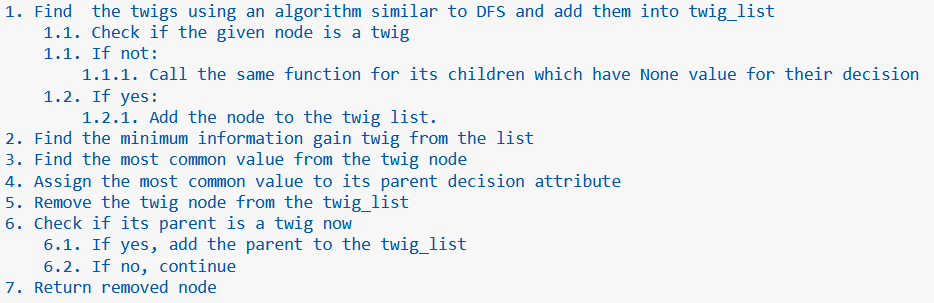

```python
    def prune(self) -> (Node, Node):
        min_gain = float('inf')
        temp_node = None
        for twig in self.twig_list:
            if twig.info_gain < min_gain:
                min_gain = twig.info_gain
                temp_node = twig
        temp_node.parent.decision = temp_node.find_most_common()
        self.twig_list.remove(temp_node)
        temp_node.parent.children.clear()
        if temp_node.parent.parent.is_twig():
            self.twig_list.append(temp_node.parent.parent)

        return temp_node, temp_node.parent

    def revert_prune(self, twig: Node, parent: Node) -> None:
        if twig.parent.parent.is_twig():
            self.twig_list.remove(twig.parent.parent)
        parent.children.append(twig)
        self.twig_list.append(twig)
        parent.decision = None

    def find_twigs(self, tree_node: Node) -> None:
        if not tree_node.is_twig():
            for child in tree_node.children:
                if child.decision is None:
                    self.find_twigs(child.children[0])
        else:
            self.twig_list.append(tree_node)
            return

```

### 2.2. Pruning Results

In this section we compare the not-pruned ID3 vs pruned ID3 and how it effects the accuracy on test set. Our training, validation, test set proportions are same as the ones in the pdf (0.6, 0.2, 0.2) respectively.

#### Before Prune

In [14]:
training_data = []
for data_num in range(len(k_fold_data)-2):
    training_data.extend(k_fold_data[data_num])
validation_data = k_fold_data[-1]
test_data = k_fold_data[-2]

d_tree = DecisionTree()
d_tree.create_tree(training_data, df_columns)

start_time = time.time()

predictions = []
for test in test_data:
    predictions.append(d_tree.predict(test))

end_time = time.time()

accuracy_before = calculate_accuracy(test_data, predictions)
precision_before = calculate_precision(test_data, predictions)
recall_before = calculate_recall(test_data, predictions)
f1_score_before = calculate_f1_score(recall_before, precision_before)

print(f"Accuracy: {accuracy_before}")
print(f"Precision: {precision_before}")
print(f"Recall: {recall_before}")
print(f"F1 Score: {f1_score_before}\n")
print(f"The computation time is {end_time-start_time} seconds\n\n")

Accuracy: 0.7687074829931972
Precision: 0.3673469387755102
Recall: 0.45
F1 Score: 0.4044943820224719

The computation time is 0.001997232437133789 seconds




##### Rules of the Tree before Pruning

In [15]:
d_tree.print_rules(d_tree.root, [])

(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = High) ^ (Age = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = High) ^ (Age = High) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Mid) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Low) ^ (Education = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Low) ^ (Education = Mid) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Rarely) ^ (RelationshipSatisfaction = High) ^ (MonthlyRate = High) ^ (TrainingTimesLastYear = Low) ^ (DailyRate = Mid) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Rarely) ^ (RelationshipSatisfaction = High) ^ (MonthlyRate = High) ^ (TrainingTimesLastYear = Low) ^ (DailyRate = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Trave

#### After Prune

In [16]:
d_tree.find_twigs(d_tree.root)
pruned_nodes = []
while True:
    predictions = []
    for data in validation_data:
        predictions.append(d_tree.predict(data))
    last_accuracy = calculate_accuracy(validation_data, predictions)
    
    # Deletes the least information gain from the tree but stores it locally in case of reverting the operation
    del_node, parent_node = d_tree.prune()
    pruned_nodes.append(del_node)
    predictions = []
    for data in validation_data:
        predictions.append(d_tree.predict(data))
    current_accuracy = calculate_accuracy(validation_data, predictions)

    if last_accuracy <= current_accuracy:
        # Deletes the node completely, continues to the next step
        del del_node
        continue
    d_tree.revert_prune(del_node, parent_node)
    pruned_nodes.remove(del_node)
    break

In [17]:
start_time = time.time()

predictions = []
for test in test_data:
    predictions.append(d_tree.predict(test))
    
end_time = time.time()
    
accuracy = calculate_accuracy(test_data, predictions)
precision = calculate_precision(test_data, predictions)
recall = calculate_recall(test_data, predictions)
f1_score = calculate_f1_score(recall, precision)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}\n")
print(f"The computation time is {end_time-start_time} seconds\n\n")

Accuracy: 0.7789115646258503
Precision: 0.3958333333333333
Recall: 0.475
F1 Score: 0.43181818181818177

The computation time is 0.0009968280792236328 seconds




##### Rules of Pruned Tree

In [18]:
d_tree.print_rules(d_tree.root, [])

(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = High) ^ (Age = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = High) ^ (Age = High) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Mid) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Low) ^ (Education = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Frequently) ^ (DailyRate = Low) ^ (Education = Mid) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Rarely) ^ (RelationshipSatisfaction = High) ^ (MonthlyRate = High) ^ (TrainingTimesLastYear = Low) ^ (DailyRate = Mid) -> No 
(JobRole = Sales Representative) ^ (BusinessTravel = Travel_Rarely) ^ (RelationshipSatisfaction = High) ^ (MonthlyRate = High) ^ (TrainingTimesLastYear = Low) ^ (DailyRate = Low) -> Yes 
(JobRole = Sales Representative) ^ (BusinessTravel = Trave

#### Pruned Nodes

In [19]:
for node in pruned_nodes:
    path = [node]
    temp_node = node
    while temp_node.parent is not None:
        temp_node = temp_node.parent
        path.append(temp_node)
    for index in range(len(path)-1, -1, -1):
        if len(path[index].children) == 1:
            print(f"{path[index].title}) ^ ", end="")
        else:
            if index == 0:
                print(f"({path[index].title} (PRUNED))")
                print(f"- Most common value of ({path[index].title}) is ({path[index].find_most_common()})")
                print(f"- The counts of Yes-No options in order {path[index].count['general']}\n\n")
            else:
                print(f"({path[index].title} -> ", end="")

(JobRole -> Sales Executive) ^ (StockOptionLevel -> Mid) ^ (TrainingTimesLastYear -> (Mid -> (Age (PRUNED))
- Most common value of (Age) is (No)
- The counts of Yes-No options in order (1, 46)


(JobRole -> Sales Executive) ^ (StockOptionLevel -> High) ^ (DistanceFromHome -> (Low -> (Age (PRUNED))
- Most common value of (Age) is (No)
- The counts of Yes-No options in order (1, 28)


(JobRole -> (Manufacturing Director -> (YearsAtCompany -> (Low -> (NumCompaniesWorked -> (Low -> (Age (PRUNED))
- Most common value of (Age) is (No)
- The counts of Yes-No options in order (3, 32)


(JobRole -> Research Scientist) ^ (StockOptionLevel -> Mid) ^ (DailyRate -> (Low -> (YearsSinceLastPromotion (PRUNED))
- Most common value of (YearsSinceLastPromotion) is (No)
- The counts of Yes-No options in order (1, 17)


(JobRole -> Sales Executive) ^ (StockOptionLevel -> High) ^ (DistanceFromHome -> (High -> (Age (PRUNED))
- Most common value of (Age) is (No)
- The counts of Yes-No options in order (2, 6)


These nodes are deleted because as we can see the gap between the count values of "Yes" and "No" options are huge. So, instead of keeping these nodes, we can take the most common value from their counts and assign it to the parent node instead. It will result in a minimal difference in the accuracy of the tree, on the other hand, increase the performance and efficiency. As we prune the tree more, the depth level most likey will decrease and we will reach the results faster.

##### Comparison between before pruning - after pruning

In [20]:
print("\t\t%s\t\t%s" % ("Before", "After"))
print("Accuracy\t%.3f\t\t%.3f" % (accuracy_before, accuracy))
print("Precision\t%.3f\t\t%.3f" % (precision_before, precision))
print("Recall\t\t%.3f\t\t%.3f" % (recall_before, recall))
print("F1 Score\t%.3f\t\t%.3f" % (f1_score_before, f1_score))

		Before		After
Accuracy	0.769		0.779
Precision	0.367		0.396
Recall		0.450		0.475
F1 Score	0.404		0.432


After the pruning process we see that the model keeps the metrics around the same value or slightly better compare to the normal tree. The tree's computation time also also decreased with pruning operation. As we prune the tree more since it gets less deep, the run time for predictions will decrease while doing the same amount of correct predictions. At the same time, since the nodes that are not used, are deleted, it improves the space efficiency as well. It also solves the problem with overfitting the data with reducing our conjuctions in our rules.